### Creating A Model to Predict Walk Scores in Seattle

The dataset I'm using is based on 1000 random coordinates within the Seattle city limits. Based on these 1000 random coordinates, I merged on demographic data from the census tract that encompasses the coordinates. To round out the feature set, I definied a ammenity and distance combinations that I thought would be imporant for walkability. I queried these combinations using the Location IQ API. Then I tried to evaluate the surrounding street network within .25 km these points. I used the Open Street Maps API for this. Lastly, I merged information about the zoning features of the randomly generated points from data downloaded from the City of Seattle. The data on census demographics is from 2020, dat on ammenities, street networks, and zonign are from 2022.

The code that helped assemble this dataset was largely borrowed from Perry Johnson's "Walk Score" project. This project can be found [here](https://github.com/perryrjohnson/Walk-Score).

Census Tract Features:
- Population
- Population Density

Ammenity and Distances:
- Number of restaurants within 1 km
- Number of schools within 1 km
- Number of parks within 1 km
- Number of Bus Stations within 10 km
- Number of Super Markets within 1 km
- Number of pubs within 1 km
- Number of parks within 2.5 km
- Number of restaurants within 1.5 km

Surrounding Street Network:
- Number of intersections
- Mean number of streets that emanate from each node
- Circuity is the sum of edge lengths divided by the sum of straight-line distances between edge endpoints. Calculates straight-line distance as euclidean distance if projected or great-circle distance if unprojected.
- Street Length Average: Total street segment length / count of street segments
- Distance to closest highway 
- Distance to closest primary road 
- Distance to closest secondary road 
- Distance to closest intersection
- Distance to closest traffic signal

Zoning Features:
- Zoned for light rail
- Zoned as pedestrian zone
- Zoned as Historic
- Zoning Class
- Distance to nearest residental zoned area
- Distance to nearest commerical zoned area
- Distance to nearest industrial zoned area

## Research Question

The research question I'm trying to answer is: 

What are the most important features to Redfin's walk score?

I'm trying to predict the walk score of a given random coordinates in Seattle. 
In this project, supervised learning will be done to evaluate my model vs. the walk scored from Redfin's model.

This algortithm will help answer the research question as we can evaluate the final weights of the input features after the model is tuned to see which features carry the most weight in determining walk score.

# Model Development

In [1]:
# import packages
import pandas as pd
import json
import numpy as np
import requests
import random
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree, ensemble

## Reading in Data

In [2]:
data_df = pd.read_csv('Data/master_walk_score_comp.csv', index_col=0)

In [3]:
data_df.head()

,lat_left,lon_left,GEOID,restaurant_count,school_count,park_count,bus_station_count,supermarket_count,pub_count,parkwide_count,...,population,AREA_ACRES,tract,geometry_y,Land_Area_Km2,pop_den,industry_dist,commercial_dist,residential_dist,walk_score
0,47.648701,-122.362286,53033005901,10,1,5,3,1,9,10,...,3570,235.297362,5901,POLYGON ((1178008.9642270755 852317.9935750181...,0.952215,3749.151383,0.000000,345.834513,103.157745,70
1,47.658157,-122.373453,53033005901,10,0,2,1,4,10,10,...,3570,235.297362,5901,POLYGON ((1178008.9642270755 852317.9935750181...,0.952215,3749.151383,0.000000,293.421351,360.651397,53
2,47.653362,-122.370374,53033005901,8,1,3,1,0,3,10,...,3570,235.297362,5901,POLYGON ((1178008.9642270755 852317.9935750181...,0.952215,3749.151383,97.780974,130.475997,0.000000,64
3,47.694938,-122.304282,53033002100,2,5,2,7,0,2,10,...,4423,337.392028,2100,POLYGON ((1195070.9481855484 864684.7671727433...,1.365378,3239.395258,1886.512436,87.723180,0.000000,57
4,47.690396,-122.305112,53033002100,5,5,4,7,0,3,10,...,4423,337.392028,2100,POLYGON ((1195070.9481855484 864684.7671727433...,1.365378,3239.395258,1922.132313,63.104194,0.000000,64


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lat_left              629 non-null    float64
 1   lon_left              629 non-null    float64
 2   GEOID                 629 non-null    int64  
 3   restaurant_count      629 non-null    int64  
 4   school_count          629 non-null    int64  
 5   park_count            629 non-null    int64  
 6   bus_station_count     629 non-null    int64  
 7   supermarket_count     629 non-null    int64  
 8   pub_count             629 non-null    int64  
 9   parkwide_count        629 non-null    int64  
 10  restaurantwide_count  629 non-null    int64  
 11  intersection_count    629 non-null    int64  
 12  streets_per_node_avg  629 non-null    float64
 13  circuity_avg          629 non-null    float64
 14  street_length_avg     629 non-null    float64
 15  geometry              6

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

In [6]:
features = ['restaurant_count',
            'school_count',
            'park_count',
            'bus_station_count',
            'supermarket_count',
            'pub_count',
            'parkwide_count',
            'restaurantwide_count',
            'intersection_count',
            'streets_per_node_avg',
            'circuity_avg',
            'street_length_avg',
            'closest_highway',
            'closest_primary',
            'corner_dist',
            'signal_dist',
            'HISTORIC',
            'PEDESTRIAN',
            'LIGHTRAIL',
            'CLASS_DESC',
            'population',
            'Land_Area_Km2',
            'pop_den',
            'industry_dist',
            'commercial_dist',
            'residential_dist']

data_features = data_df[features]
data_features.info()          

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   restaurant_count      629 non-null    int64  
 1   school_count          629 non-null    int64  
 2   park_count            629 non-null    int64  
 3   bus_station_count     629 non-null    int64  
 4   supermarket_count     629 non-null    int64  
 5   pub_count             629 non-null    int64  
 6   parkwide_count        629 non-null    int64  
 7   restaurantwide_count  629 non-null    int64  
 8   intersection_count    629 non-null    int64  
 9   streets_per_node_avg  629 non-null    float64
 10  circuity_avg          629 non-null    float64
 11  street_length_avg     629 non-null    float64
 12  closest_highway       629 non-null    float64
 13  closest_primary       629 non-null    float64
 14  corner_dist           629 non-null    float64
 15  signal_dist           6

In [7]:
target = data_df['walk_score']

In [8]:
#need dummy variables
data_dummies = pd.get_dummies(data_features, columns=['CLASS_DESC','HISTORIC','LIGHTRAIL','PEDESTRIAN'])
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   restaurant_count                     629 non-null    int64  
 1   school_count                         629 non-null    int64  
 2   park_count                           629 non-null    int64  
 3   bus_station_count                    629 non-null    int64  
 4   supermarket_count                    629 non-null    int64  
 5   pub_count                            629 non-null    int64  
 6   parkwide_count                       629 non-null    int64  
 7   restaurantwide_count                 629 non-null    int64  
 8   intersection_count                   629 non-null    int64  
 9   streets_per_node_avg                 629 non-null    float64
 10  circuity_avg                         629 non-null    float64
 11  street_length_avg               

In [9]:
#Rename Variables for ML
X = data_dummies.copy()
y = data_df['walk_score']

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print('Train size:', len(y_train))
print('Test size:', len(y_test))

Train size: 421
Test size: 208


## Scaling Features

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Build Model

In [12]:
#Default Params
mlp = MLPRegressor(hidden_layer_sizes = (100,), 
                  solver = 'adam',
                  learning_rate_init = .001,
                  max_iter = 200,
                  random_state = 1, 
                   n_iter_no_change=10)

In [13]:
mlp.fit(X_train,y_train)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(random_state=1)

In [14]:
#Default Params
mlp = MLPRegressor(hidden_layer_sizes = (100,), 
                  solver = 'adam',
                  learning_rate_init = .001,
                  max_iter = 2000,
                  random_state = 1, 
                   n_iter_no_change=10)

In [15]:
mlp.fit(X_train,y_train)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=2000, random_state=1)

In [16]:
#R-sqaured
mlp.score(X,y)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


-1053171.6183212262

## Tuning Hidden Layers for Stocastic Gradient Decent Solver

In [17]:
results_list = []
for hidden_layers in range(1,5,1):
    mlp = MLPRegressor(hidden_layer_sizes = (100,)*hidden_layers, 
                  solver = 'adam',
                  learning_rate_init = .001,
                  max_iter = 1000,
                  random_state = 1,
                  n_iter_no_change=5)
    accuracy_results = cross_val_score(mlp, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([hidden_layers, 100 * np.mean(accuracy_results)])
    
df_results_list_mlp = pd.DataFrame(results_list, columns=["hidden_layers", "Score"])

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/srv/conda/envs/notebook/lib

Text(0, 0.5, 'Score')

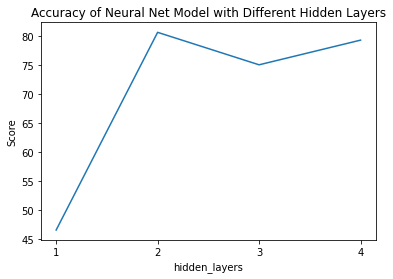

In [18]:
fig, ax = plt.subplots()
df_results_list_mlp.set_index("hidden_layers")["Score"].plot(ax = ax)
ax.set_title("Accuracy of Neural Net Model with Different Hidden Layers")
ax.set_xticks(list(range(1,5,1)))
ax.set_ylabel("Score")

## Tuning Hidden Layers with LBFGS Solver

In [19]:
results_list = []
for hidden_layers in range(1,10,1):
    mlp = MLPRegressor(hidden_layer_sizes = (100,)*hidden_layers, 
                  solver = 'lbfgs',
                  max_iter = 2000,
                  random_state = 1)
    accuracy_results = cross_val_score(mlp, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([hidden_layers, 100 * np.mean(accuracy_results)])
    
df_results_list_mlp = pd.DataFrame(results_list, columns=["hidden_layers", "Score"])

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (sta

Text(0, 0.5, 'Score')

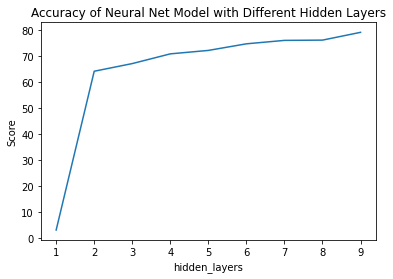

In [20]:
fig, ax = plt.subplots()
df_results_list_mlp.set_index("hidden_layers")["Score"].plot(ax = ax)
ax.set_title("Accuracy of Neural Net Model with Different Hidden Layers")
ax.set_xticks(list(range(1,10,1)))
ax.set_ylabel("Score")

## Tuning Number of Nodes

In [21]:
results_list = []
for num_nodes in range(1,200,10):
    hidden_layers = 2
    mlp = MLPRegressor(hidden_layer_sizes = (num_nodes,)*hidden_layers, 
                  solver = 'lbfgs',
                  max_iter = 2000,
                  random_state = 1)
    accuracy_results = cross_val_score(mlp, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([num_nodes, 100 * np.mean(accuracy_results)])
    
df_results_list_mlp = pd.DataFrame(results_list, columns=["hidden_layers", "Score"])

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (sta

Text(0, 0.5, 'Score')

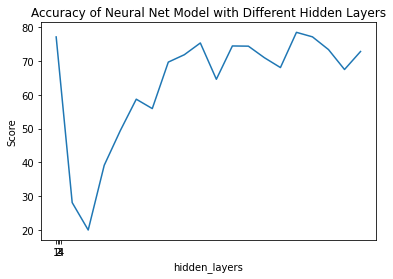

In [22]:
fig, ax = plt.subplots()
df_results_list_mlp.set_index("hidden_layers")["Score"].plot(ax = ax)
ax.set_title("Accuracy of Neural Net Model with Different Hidden Layers")
ax.set_xticks(list(range(1,5,1)))
ax.set_ylabel("Score")

## Adaboost Model

### Tuning N Estimators

In [23]:
results_list = []
for n_estimator in range(1,50,1):
    depth = 3
    adaboost = ensemble.AdaBoostRegressor(n_estimators = n_estimator,
                                          base_estimator = tree.DecisionTreeRegressor(max_depth= depth))
    accuracy_results = cross_val_score(adaboost, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([n_estimator, 100 * np.mean(accuracy_results)])
    
df_results_list_adaboost = pd.DataFrame(results_list, columns=["n_estimators", "Acc"])

Text(0, 0.5, 'Accuracy / %')

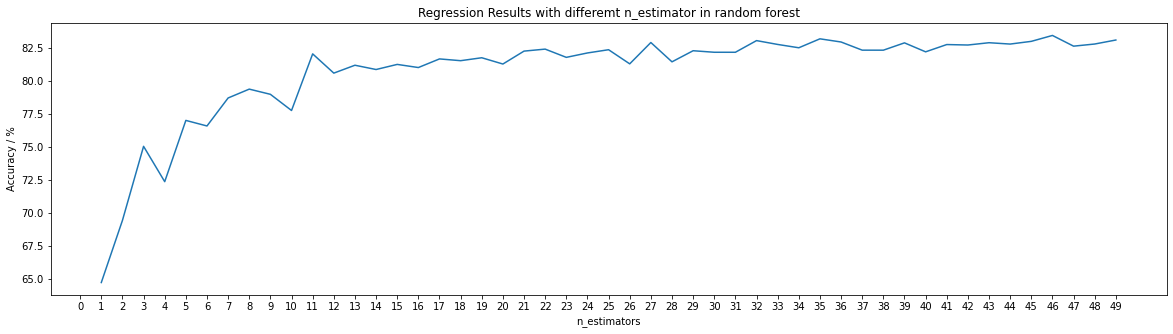

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))
df_results_list_adaboost.set_index("n_estimators")["Acc"].plot(ax = ax)
ax.set_title("Regression Results with differemt n_estimator in random forest")
ax.set_xticks(list(range(0,50,1)))
ax.set_ylabel("Accuracy / %")

In [25]:
results_list = []
for n_estimator in range(1,20,1):
    depth = 8
    adaboost = ensemble.AdaBoostRegressor(n_estimators = n_estimator,
                                                  base_estimator = tree.DecisionTreeRegressor(
                                                      max_depth= depth))
    accuracy_results = cross_val_score(adaboost, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([n_estimator, 100 * np.mean(accuracy_results)])
    
df_results_list_adaboost = pd.DataFrame(results_list, columns=["n_estimators", "Acc"])

Text(0, 0.5, 'Accuracy / %')

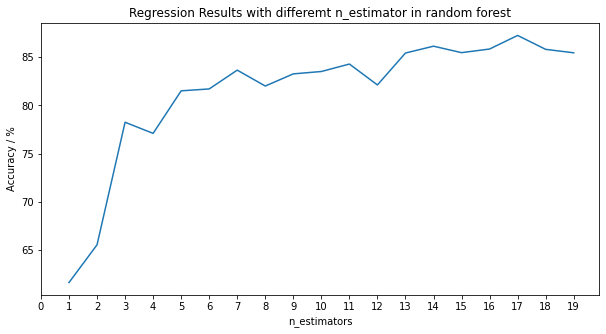

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
df_results_list_adaboost.set_index("n_estimators")["Acc"].plot(ax = ax)
ax.set_title("Regression Results with differemt n_estimator in random forest")
ax.set_xticks(list(range(0,20,1)))
ax.set_ylabel("Accuracy / %")

### Tuning Max Depth

In [27]:
results_list = []
for depth in range(1,30,1):
    n_estimator = 10
    adaboost = ensemble.AdaBoostRegressor(n_estimators = n_estimator,
                                          base_estimator = tree.DecisionTreeRegressor(max_depth= depth))
    accuracy_results = cross_val_score(adaboost, 
                                       X_train, 
                                       y_train,
                                       cv=5)
    results_list.append([depth, 100 * np.mean(accuracy_results)])
    
df_results_list_adaboost = pd.DataFrame(results_list, columns=["max_depths", "Acc"])

Text(0, 0.5, 'Accuracy / %')

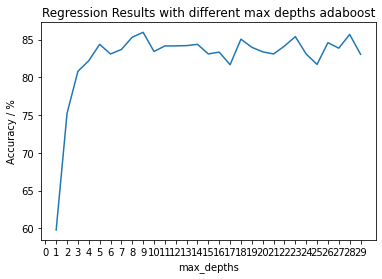

In [28]:
fig, ax = plt.subplots()
df_results_list_adaboost.set_index("max_depths")["Acc"].plot(ax = ax)
ax.set_title("Regression Results with different max depths adaboost")
ax.set_xticks(list(range(0,30,1)))
ax.set_ylabel("Accuracy / %")

### Tuned Adaboost Model
- n_estimators = 8
- max_depth = 6

In [29]:
n_estimator = 8
depth = 6
adaboost = ensemble.AdaBoostRegressor(n_estimators = n_estimator,
                                          base_estimator = tree.DecisionTreeRegressor(max_depth = depth))
accuracy_results = cross_val_score(adaboost, X_train, y_train, cv=5)

print("Tuned model accuracy:",100 * np.mean(accuracy_results))

Tuned model accuracy: 83.1583307081678


## Model Accuracy

Tinkering with the parameters of the Neural Network Model really only helped the model accuracy marginally. It required a lot of tinkering just to get the model to converge. On the training data this tuned neural net model was about 77% accurate. 

The adaboost model got a lot better with tinkering. Adding a few more N_estimators and increasing the max depth slightly increased the model accuracy to about 84%.

## Challenges

I ran into the challenge that my model using the 'adam' solver, a form of stocatstic gradient descent', was not converging even after 1000 interations. This is likely due to the smaller dataset that was gathered. Neural networks are especially good on large amounts of data. In this case, we only have about 600 data points, which is probably not large enough for a neural net train enough to obtain a high degree of accuracy. Also, there's no telling which features went into the black box of Redfin's Walk Score. We can only tune the model as well as we have features that explain the target variable. If there is a major feature missing then we will not have an accurate model.  

## Harms of the Model

The benefits to the model are that theoretically we could decipher what the Redfin Walk Score uses to calculate the walk score for their properties. If walk scores don't seem accurate to certain groups such as children, the disabled, or the elderly, then we can help adjust the walk score model to be more inclusive. Another potential benefit to this model would be that it is open source. Redfin's model is propreitary. Redfin has to give permission to researchers and third-parties that want to access their algorithm. However, there are ethical implications of trying to replicate and publicize proprietary work. 

One potential harm is that models like walk scores are difficult to generalize to everyone. Firstly, walk scores alienate the population that cannot walk. In addition, they could be very poor represnations for certain other groups such as children. Another harm is that people will trust too much in a walk score and base a large financial decision on a model that is more meant to be a datapoint. Just because this model or Refin's says that a home has a walk score of 95/100 does not mean that it is better for walking for a specific person's needs and wants than a home with a 60/100 walk score. 

## Future research

I would really like to have human generated data as the target variable for a model. If I had data from different real people asking them how walkable their current homes are, how often they walk to retail/bars/grocery stores, how long it takes them. Once there's enough data collected through that, I could used a KNN technique to estimate what walk scores would be for their neighbors. 